# 信贷申请评分卡_A卡案例

主要项目流程：数据获取、数据清洗(特征初筛)、特征工程、模型建立、模型评价、模型优化等

In [170]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import catboost as cat
import lightgbm as lgb
import xgboost as xgb
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 1.数据获取

In [2]:
# 数据基本描述：信贷申请数据--42535个样本，144个特征

In [3]:
data = pd.read_excel('LoanStats_2018Q3.xlsx')
data.shape

(42535, 144)

In [4]:
# 特征列表
feature_list = list(data)
print(feature_list)
df = data.copy()
df.head()

['id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose', 'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'policy_code', 'application_type', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'mths

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,1,5000,5000,4975.0,36 months,0.1065,162.87,B,B2,NaN,...,NaN,NaN,Cash,N,NaT,NaN,NaT,NaN,NaN,NaN
1,2,2500,2500,2500.0,60 months,0.1527,59.83,C,C4,Ryder,...,NaN,NaN,Cash,N,NaT,NaN,NaT,NaN,NaN,NaN
2,3,2400,2400,2400.0,36 months,0.1596,84.33,C,C5,NaN,...,NaN,NaN,Cash,N,NaT,NaN,NaT,NaN,NaN,NaN
3,4,10000,10000,10000.0,36 months,0.1349,339.31,C,C1,AIR RESOURCES BOARD,...,NaN,NaN,Cash,N,NaT,NaN,NaT,NaN,NaN,NaN
4,5,3000,3000,3000.0,60 months,0.1269,67.79,B,B5,University Medical Group,...,NaN,NaN,Cash,N,NaT,NaN,NaT,NaN,NaN,NaN


# 2.数据清洗（特征初筛）

In [5]:
# 2.1 申请评分卡使用的数据不能是借款人借款后的信息，需删除18个特征
del_feature_list = ['sub_grade','grade','initial_list_status','out_prncp','out_prncp_inv','total_pymnt','total_pymnt_inv',
                    'total_rec_prncp','total_rec_int','total_rec_late_fee','recoveries','collection_recovery_fee','last_pymnt_d',
                    'last_pymnt_amnt','last_credit_pull_d','collections_12_mths_ex_med','policy_code','disbursement_method']
print(df.shape)
df_01 = df.copy().drop(columns=del_feature_list, axis=1)
df_01.shape

(42535, 144)


(42535, 126)

In [6]:
# 2.2 删除客户隐私的字段:['emp_title','title']
customer_info = ['emp_title','title']
df_02 = df_01.drop(columns=customer_info, axis=1)
df_02.shape

(42535, 124)

In [7]:
# 2.3 去重，删除空行
df_03 = df_02.drop_duplicates('id').dropna(axis=0, how='all')
df_03.shape

(42535, 124)

In [8]:
# 2.4 删除缺失率大于0.95的字段
# is_null = [df_03[i_feature].isnull().sum() for i_feature in list(df_03)]
cols_null = []
for col_null in df_03.columns:
    if df_03[col_null].isnull().sum() > (df_03.shape[0])*0.95:
        cols_null.append(col_null)
print(len(cols_null))
df_04 = df_03.drop(cols_null, axis=1)
df_04.shape

86


(42535, 38)

In [9]:
# 例：唯一值
# 2.5 判断每个特征值的分布，若存在某一个值占比超过95%，则删除(分箱前提)
col_handle = []
for col_ in df_04.columns:
    if df_04[col_].value_counts().max() > df_04.shape[0]*0.95:
        col_handle.append(col_)
print(col_handle)
df_05 = df_04.drop(col_handle, axis=1)
df_05.shape

['pymnt_plan', 'application_type', 'acc_now_delinq', 'chargeoff_within_12_mths', 'delinq_amnt', 'tax_liens', 'hardship_flag', 'debt_settlement_flag']


(42535, 30)

In [10]:
# 2.6 删除id号
df_06 = df_05.drop('id', axis=1)
df_06.shape

(42535, 29)

In [11]:
# 2.7 查看借款期限，并选出借款36期的样本
print(df_06['term'].value_counts())
df_06['term'] = df_06['term'].replace(' 36 months', 36).replace(' 60 months', 60)
df_final = df_06[df_06['term']==36]
df_final.shape

 36 months    31534
 60 months    11001
Name: term, dtype: int64


(31534, 29)

In [12]:
# 2.8 数据类型查看与转换
def obj_feature(df_final):
    obj_feature = []
    for obj_f in df_final.columns:
        if df_final[obj_f].dtypes == 'object':
            obj_feature.append(obj_f)
    print(obj_feature)
    return obj_feature

obj_feature = obj_feature(df_final)

['emp_length', 'home_ownership', 'verification_status', 'loan_status', 'desc', 'purpose', 'zip_code', 'addr_state', 'delinq_2yrs', 'total_acc']


In [13]:
# 特征值查看
# 1) emp_length--工作年限
df_finals = df_final.copy()
# print(df_finals['emp_length'].value_counts())
print(df_finals['emp_length'].unique())

def emp_length_new(x):
    if x=='< 1 year':
        return 0
    elif x=='1 year':
        return 1
    elif x=='10+ years':
        return 11
    elif str(x)=='nan':
        return np.nan
    else:
        return x.replace(' years', '')
    
df_finals['emp_length'] =df_finals['emp_length'].map(lambda x: emp_length_new(x))
df_finals['emp_length'].unique()
df_finals['emp_length'] = df_finals['emp_length'].apply(pd.to_numeric, errors='coerce')
# print('===================================')

# 2) home_ownership--房产权:类别型特征
# print(df_finals['home_ownership'].value_counts())
# print('===================================')

# 3) verification_status--验证状态:类别型特征
# print(df_finals['verification_status'].value_counts())
# print('===================================')

# 4) loan_status--贷款状态:y
# df_finals['loan_status'].value_counts()
df_finals['loan_status'] = df_finals['loan_status'].copy().map(lambda x: 1 if 'Charged Off' in x else 0)
# print(df_finals['loan_status'].value_counts())
# print('===================================')

# 5) desc--自然语言模块，暂不考虑
df_finals = df_finals.drop('desc', axis=1)
# print('===================================')

# 6) purpose--用途：类别型特征
# print(df_finals['purpose'].value_counts())
# print('===================================')

# 7) zip_code--邮政编码
df_finals = df_finals.drop('zip_code', axis=1)
# print('===================================')

# 8) addr_state--地址状态：类别型特征
# print(df_finals['addr_state'].value_counts())
# print('===================================')

# 9) delinq_2yrs：过去两年逾期次数
# print(df_finals['delinq_2yrs'].value_counts())
set(df_finals['delinq_2yrs'])
df_finals['delinq_2yrs'] = df_finals['delinq_2yrs'].apply(pd.to_numeric, errors='coerce')

# 10) total_acc
set(df_finals['total_acc'])
df_finals['total_acc'] = df_finals['total_acc'].apply(pd.to_numeric, errors='coerce')

['10+ years' '3 years' '9 years' '< 1 year' '4 years' '1 year' '6 years'
 '5 years' '2 years' '7 years' '8 years' nan]


In [14]:
# 2.9 特征衍生：loan_amnt贷款额度，annual_inc年收入（贷款收入比）
# df_finals[['loan_amnt','annual_inc', 'issue_d', 'earliest_cr_line', 'next_pymnt_d']]
df_finals['pnt_loan_annual'] = df_finals.loan_amnt/df_finals.annual_inc
print(df_finals.shape)
df_finals.columns

(31534, 28)


Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'issue_d', 'loan_status', 'purpose',
       'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'next_pymnt_d', 'pub_rec_bankruptcies', 'pnt_loan_annual'],
      dtype='object')

In [15]:
# 特征列表分类
# 离散(类别型)特征:home_ownership, verification_status, purpose, addr_state
char_feature = ['emp_length', 'home_ownership', 'verification_status', 'purpose', 'addr_state']

# 日期型特征：issue_d，earliest_cr_line，next_pymnt_d
time_feature = ['issue_d', 'earliest_cr_line', 'next_pymnt_d']
df_finals[time_feature] = df_finals[time_feature].apply(pd.to_datetime)

# 标签
df_label=['loan_status']

# 连续型特征
num_feature = df_finals.copy().columns.drop(time_feature).drop(char_feature).drop(df_label)
for i_f in num_feature:
    df_finals[i_f] = df_finals[i_f].apply(pd.to_numeric, errors='coerce')
print(len(num_feature))

19


In [16]:
# *数据探索
# 类别型(离散)特征: 每个特征值分布概率值
def data_distributed(df_finals, char_feature):
    rate_feature_all = []
    for col in char_feature:
        result = df_finals[col].value_counts()
        #print('char_feature_name:', col)
        rate_feature = []
        for v_i in range(len(result)):
            rate = result[v_i]/result.sum()
            rate_feature.append(rate)
        rate_feature = pd.Series(rate_feature).to_frame().reset_index().rename(columns={'index':'id', 0: 'rate'})
        result = pd.Series(result).to_frame().reset_index().reset_index().rename(columns={'level_0':'id', 'index':'f_name',
                                                                                          'home_ownership':'value_count'})
        rate_feature = pd.merge(result, rate_feature, on=['id']).drop('id', axis=1)
        rate_feature_all.append(rate_feature)
    return rate_feature_all

df_finals['emp_length'] = df_finals['emp_length'].astype('str')
# df_finals['emp_length'].dtypes
rate_feature_all = data_distributed(df_finals, char_feature)
# rate_feature_all

In [17]:
# 2.10 缺失值查看与处理
# 离散特征
print(df_finals[char_feature].isnull().sum())
print('==============next=============')

# 连续型特征
print(df_finals[num_feature].isnull().sum())
# 缺失值处理：-999填充
df_s = df_finals.fillna(-999)

emp_length             0
home_ownership         0
verification_status    0
purpose                0
addr_state             0
dtype: int64
==============next=============
loan_amnt                     0
funded_amnt                   0
funded_amnt_inv               0
term                          0
int_rate                      0
installment                   0
annual_inc                    4
dti                           0
delinq_2yrs                  30
inq_last_6mths               29
mths_since_last_delinq    19747
mths_since_last_record    28530
open_acc                     29
pub_rec                      29
revol_bal                     0
revol_util                   86
total_acc                    30
pub_rec_bankruptcies       1365
pnt_loan_annual               4
dtype: int64


In [18]:
# 重命名与定义y标签：贷款状态(好样本0，坏样本1)
df_s=df_s.rename(columns={'loan_status':'y'})
df_s['y'].value_counts()

0    27658
1     3876
Name: y, dtype: int64

# 3.特征工程

In [153]:
# 根据iv值、相关性、多重共线性等筛选特征

In [154]:
# 离散：计算每个特征的iv值
def cal_charf_iv(char_df, label):
#     print(char_df.shape, '\n====计算离散特征的iv值====')
    all_feature_iv = []
    char_feature_name = []
    for char_f in list(char_df):
        if char_f not in label:
            char_feature_name.append(char_f)
            #print('feature:', char_f)
            df = pd.concat([char_df[char_f], char_df[label]], axis=1)
            #print(df.shape)
            # 好样本统计
            good_df = df[df[label]==0]
            good_count = good_df[char_f].value_counts().to_frame().reset_index().rename(columns={'index':'char_value',char_f:'good_count'})
            # 坏样本统计
            bad_df = df[df[label]==1]
            bad_count = bad_df[char_f].value_counts().to_frame().reset_index().rename(columns={'index':'char_value',char_f:'bad_count'})
            # 整合
            result_df = pd.merge(good_count, bad_count, on=['char_value'])
            result_df['good_rate'] = result_df.good_count/result_df.good_count.sum() # 好客户的占比
            result_df['bad_rate'] = result_df.bad_count/result_df.bad_count.sum() # 坏客户的占比
            result_df['cum_good_rate'] = result_df.good_rate.cumsum()
            result_df['cum_bad_rate'] = result_df.bad_rate.cumsum()
            # 计算ks
            result_df['ks'] = round(abs(result_df.cum_good_rate - result_df.cum_bad_rate), 4)
            # 计算woe(优势比):ln(好客户的占比/坏客户的占比)*100%
            result_df['woe'] = np.log(result_df.good_rate/result_df.bad_rate)
            result_df['iv'] = (result_df.good_rate-result_df.bad_rate)*(result_df.woe)
            feature_iv = result_df.iv.sum()
            #print('feature_iv:',feature_iv)
            #print(str(char_f + ':'), feature_iv)
            all_feature_iv.append(feature_iv)
    feature_iv = pd.Series(all_feature_iv).to_frame().rename(columns={0:'feature_iv'})
    feature_name = pd.Series(char_feature_name).to_frame().rename(columns={0:'feature_name'})
    feature_name_iv = pd.concat([feature_name, feature_iv], axis=1)
    return feature_name_iv

# 连续型：计算每个特征的iv值
def cal_numf_iv(num_df, label):
#     print(num_df.shape, '\n=========计算连续特征的iv值=========')
    all_feature_iv = []
    num_feature_name = []
#     print(list(num_df))
    for num_f in list(num_df):
        if num_f not in label:
            #print(num_f)
            num_feature_name.append(num_f)
            # 分箱操作--等频：10等份
            df_bin = pd.qcut(df_s[num_f], 10, duplicates='drop')
            df_bin_label = pd.concat([df_bin, df_s[label]], axis=1)
            # 好样本统计
            good_bin_df = df_bin_label[df_bin_label[label]==0].rename(columns={num_f:'bin'})
            good_count = good_bin_df['bin'].value_counts().to_frame().reset_index().rename(columns={'index':'bin', 
                                                                                                    'bin':'good_count'}).sort_values(by='bin')
            # 坏样本统计
            bad_bin_df = df_bin_label[df_bin_label[label]==1].rename(columns={num_f:'bin'})
            bad_count = bad_bin_df['bin'].value_counts().to_frame().reset_index().rename(columns={'index':'bin', 
                                                                                                  'bin':'bad_count'}).sort_values(by='bin')
            # 合并统计结果
            result_df = pd.merge(good_count, bad_count, on=['bin'])
            result_df['good_rate'] = result_df.good_count/result_df.good_count.sum()
            result_df['bad_rate'] = result_df.bad_count/result_df.bad_count.sum()
            result_df['cum_good_rate'] = result_df.good_rate.cumsum()
            result_df['cum_bad_rate'] = result_df.bad_rate.cumsum()
            # 计算ks
            result_df['ks'] = round(abs(result_df.cum_good_rate - result_df.cum_bad_rate), 6)
            # 计算iv值
            result_df['woe'] = np.log(result_df.good_rate/result_df.bad_rate)
            result_df['iv'] = (result_df.good_rate-result_df.bad_rate)*(result_df.woe)
            feature_iv = result_df.iv.sum()
            all_feature_iv.append(feature_iv)
    feature_iv = pd.Series(all_feature_iv).to_frame().rename(columns={0:'feature_iv'})
    feature_name = pd.Series(num_feature_name).to_frame().rename(columns={0:'feature_name'})
    num_feature_name_iv = pd.concat([feature_name, feature_iv], axis=1)
    return num_feature_name_iv

def get_result_iv(feature_name_iv, low_th, high_th):
    # 特征iv值：评价指标
    #    a.iv<0.02, 预测效果：无明显；
    #    b.0.02=<iv<0.1, 预测效果：弱； 
    #    c.0.1=<iv<0.3, 预测效果：中等；
    #    d.0.3=<iv<0.5, 预测效果：强；
    #    e.0.5=<iv, 预测效果：需考虑；
    len_f = feature_name_iv.shape[0]
    threshold_high = feature_name_iv[feature_name_iv.feature_iv<high_th].shape[0]
    threshold_low = feature_name_iv[feature_name_iv.feature_iv>=low_th].shape[0]
    if threshold_high==len_f and threshold_low==len_f:
        print('all feature...')
    else:
        print('some feature...')
    # 选取iv值在固定范围的特征,若整体iv值不高，可稍微适当调整
    feature_sel = feature_name_iv[feature_name_iv.feature_iv>=low_th]
    feature_sels = feature_sel[feature_sel.feature_iv<high_th]
    return feature_sels

# 根据相关性、iv值，综合考虑特征
def del_feature_sub(sn_df, numf_vi, th_c):
    del_feature_sub = []
    for i in range(sn_df.shape[1]):
        for j in range(sn_df.shape[1]):
            if i==j:
                continue
            else:
                if sn_df.iloc[i][j]>=th_c:
                    numf_vi_i = numf_vi.iloc[i, 1]
                    numf_vi_j = numf_vi.iloc[j, 1]
                    if numf_vi_i>=numf_vi_j:
                        del_feature_sub.append(numf_vi.iloc[j, 0])
    del_feature_subs = list(set(del_feature_sub)) # 可删除特征字段
    return del_feature_subs

In [158]:
# 柱状图
def plot_histogram(df):
    all_feature_iv_list = list(df.feature_name)
    all_feature_iv_df = df.feature_iv
    plt.bar(range(len(all_feature_iv_list)), all_feature_iv_df, color='rgby')
    plt.show()
    
# 热力图
def plot_seaborn(df):
    plt.figure(figsize=(12, 8))
    sn.heatmap(df, annot=True)
    plt.title("The feature's heatmap")
    plt.show()

In [159]:
# 3.1 根据iv值筛选特征
# 1)离散(类别型)特征
char_df = pd.concat([df_s[char_feature], df_s['y']], axis=1)
feature_name_iv = cal_charf_iv(char_df, label='y')
feature_name_iv

# 2) 连续性特征
num_features = num_feature.copy().drop('term')
num_df = df_s[num_features]
num_df.shape
num_feature_name_iv = cal_numf_iv(num_df, label='y')
num_feature_name_iv

# 3)合并离散和连续的特征iv值
all_feature_iv = pd.concat([feature_name_iv, num_feature_name_iv],axis=0).reset_index().drop('index', axis=1)
all_feature_iv
 
# 4) 特征筛选_取iv值范围：[0.01, 0.5)
feature_sels_vi = get_result_iv(all_feature_iv, low_th=0.01, high_th=0.5)
sel_feature_ = list(feature_sels_vi.feature_name)  # 筛选后的特征列表：sel_feature_
print('特征总个数:', all_feature_iv.shape[0])
print('根据iv筛选后的剩余特征个数:',len(sel_feature_))
feature_sels_vi

some feature...
特征总个数: 23
根据iv筛选后的剩余特征个数: 17


,feature_name,feature_iv
0,emp_length,0.013553
3,purpose,0.089033
4,addr_state,0.049407
5,loan_amnt,0.015097
6,funded_amnt,0.016292
7,funded_amnt_inv,0.061025
8,int_rate,0.272160
9,installment,0.010712
10,annual_inc,0.060682
11,dti,0.013676


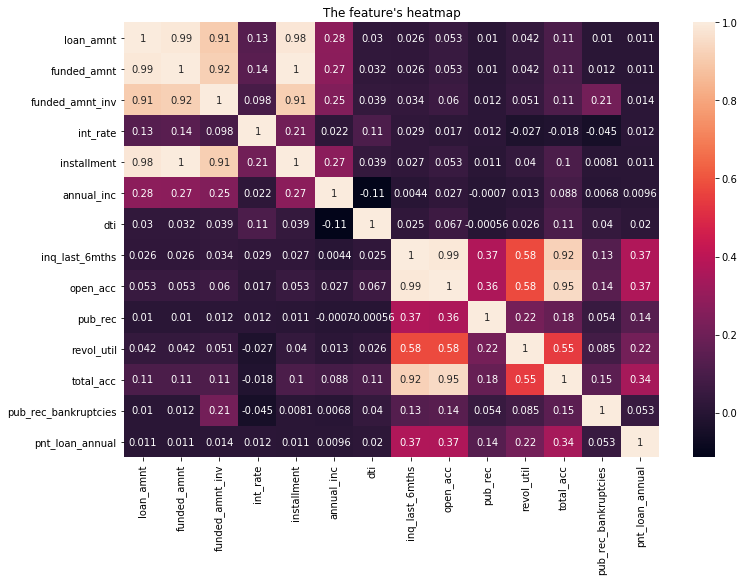

删除特征字段： 5 
 ['loan_amnt', 'funded_amnt', 'installment', 'open_acc', 'total_acc']
原特征字段： 14 
 ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 'annual_inc', 'dti', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_util', 'total_acc', 'pub_rec_bankruptcies', 'pnt_loan_annual']
新的特征字段： 9 
 ['funded_amnt_inv', 'int_rate', 'annual_inc', 'dti', 'inq_last_6mths', 'pub_rec', 'revol_util', 'pub_rec_bankruptcies', 'pnt_loan_annual']
新的所有特征字段： 12 
 ['emp_length', 'purpose', 'addr_state', 'funded_amnt_inv', 'int_rate', 'annual_inc', 'dti', 'inq_last_6mths', 'pub_rec', 'revol_util', 'pub_rec_bankruptcies', 'pnt_loan_annual']


In [161]:
# 3.2 根据相关性与iv筛选特征(连续性特征)
# 注：相关性高的两个特征(阈值0.7)，可删除iv值较小的特征
# 相关性分析：连续性特征(14个)
sub_num_feature = list(df_s[sel_feature_])[3:]
sub_char_feature = list(df_s[sel_feature_])[0:3]
sn_df = df_s[sub_num_feature].corr()
# 热力图
plot_seaborn(sn_df)
numf_vi = feature_sels_vi[3:].reset_index().drop('index', axis=1)

# 可删除特征字段
del_feature_subs = del_feature_sub(sn_df, numf_vi, th_c=0.7)
print('删除特征字段：', len(del_feature_subs), '\n', del_feature_subs)
print('原特征字段：', len(sub_num_feature), '\n', sub_num_feature)
# 新的连续特征字段
new_num_feature = [i for i in sub_num_feature if i not in del_feature_subs]
print('新的特征字段：',len(new_num_feature), '\n', new_num_feature)
# 新的所有特征字段
all_newFeature_sub = sub_char_feature + new_num_feature
print('新的所有特征字段：',len(all_newFeature_sub), '\n', all_newFeature_sub)

In [163]:
# 3.3 根据多重共线性筛选特征(连续型特征)
# 判断：
#    若VIF<3：说明基本不存在多重共线性的问题；
#    若3<VIF<10：存在一定的多重共线性，实情考虑；
#    若VIF>=10：说明问题比较严重，建议删除特征；
vif_df = df_s[new_num_feature]
print(vif_df.shape)
numF_vif = pd.DataFrame()
numF_vif['feature_name'] = vif_df.columns
numF_vif['vif_v'] = [variance_inflation_factor(vif_df.values, i) for i in range(vif_df.shape[1])]
print('最大VIF值：max(vif)=%s\n' % max(numF_vif.vif_v))  # max(vif_v)<10，均无多重共线性，不操作
numF_vif

(31534, 9)
最大VIF值：max(vif)=5.8973037330539



,feature_name,vif_v
0,funded_amnt_inv,3.227471
1,int_rate,5.897304
2,annual_inc,2.171382
3,dti,4.108529
4,inq_last_6mths,1.841611
5,pub_rec,1.158956
6,revol_util,1.515761
7,pub_rec_bankruptcies,1.117218
8,pnt_loan_annual,1.159677


# 4.模型建立

In [166]:
# 数据准备_all_newFeature_sub
df_model = df_s[all_newFeature_sub]
df_model.shape

(31534, 12)

In [171]:
# 4.1 CatBoost
